In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression

from doubleml.did import DoubleMLDIDMulti
from doubleml.data import DoubleMLPanelData

from doubleml.did.datasets import make_did_CS2021

# simulate data
n_obs = 5000
df = make_did_CS2021(n_obs, dgp_type=1, n_periods=8, n_pre_treat_periods=4, time_type="datetime")
df["ite"] = df["y1"] - df["y0"]

In [2]:
# rename for plotting
df["First Treated"] = df["d"].dt.strftime("%Y-%m").fillna("Never Treated")
df.head()

,id,y,y0,y1,d,t,Z1,Z2,Z3,Z4,ite,First Treated
0,0,214.177554,214.177554,215.868822,NaT,2025-01-01,-0.480522,0.943682,-0.218748,0.91184,1.691268,Never Treated
1,0,218.358132,218.358132,218.343452,NaT,2025-02-01,-0.480522,0.943682,-0.218748,0.91184,-0.014681,Never Treated
2,0,220.434292,220.434292,219.332694,NaT,2025-03-01,-0.480522,0.943682,-0.218748,0.91184,-1.101598,Never Treated
3,0,221.413949,221.413949,223.756078,NaT,2025-04-01,-0.480522,0.943682,-0.218748,0.91184,2.342129,Never Treated
4,0,224.374383,224.374383,223.932041,NaT,2025-05-01,-0.480522,0.943682,-0.218748,0.91184,-0.442342,Never Treated


In [3]:

# Create aggregation dictionary for means
def agg_dict(col_name):
    return {
        f'{col_name}_mean': (col_name, 'mean'),
        f'{col_name}_lower_quantile': (col_name, lambda x: x.quantile(0.05)),
        f'{col_name}_upper_quantile': (col_name, lambda x: x.quantile(0.95))
    }

# Calculate means and confidence intervals
agg_dictionary = agg_dict("y") | agg_dict("ite")
# convert "d" to month period

# fill NaT values since they are not supported by groupby
agg_df = df.groupby(["t", "First Treated"]).agg(**agg_dictionary).reset_index()
agg_df.head()

,t,First Treated,y_mean,y_lower_quantile,y_upper_quantile,ite_mean,ite_lower_quantile,ite_upper_quantile
0,2025-01-01,2025-05,209.300753,201.766880,217.039317,-0.026614,-2.304513,2.419752
1,2025-01-01,2025-06,210.202290,202.774666,217.882044,-0.001342,-2.241443,2.269269
2,2025-01-01,2025-07,212.076382,204.560539,219.492164,0.069318,-2.108613,2.353309
3,2025-01-01,2025-08,213.364195,205.573922,221.975874,-0.041680,-2.449703,2.358228
4,2025-01-01,Never Treated,215.096598,206.449830,225.569888,-0.050251,-2.313271,2.264483


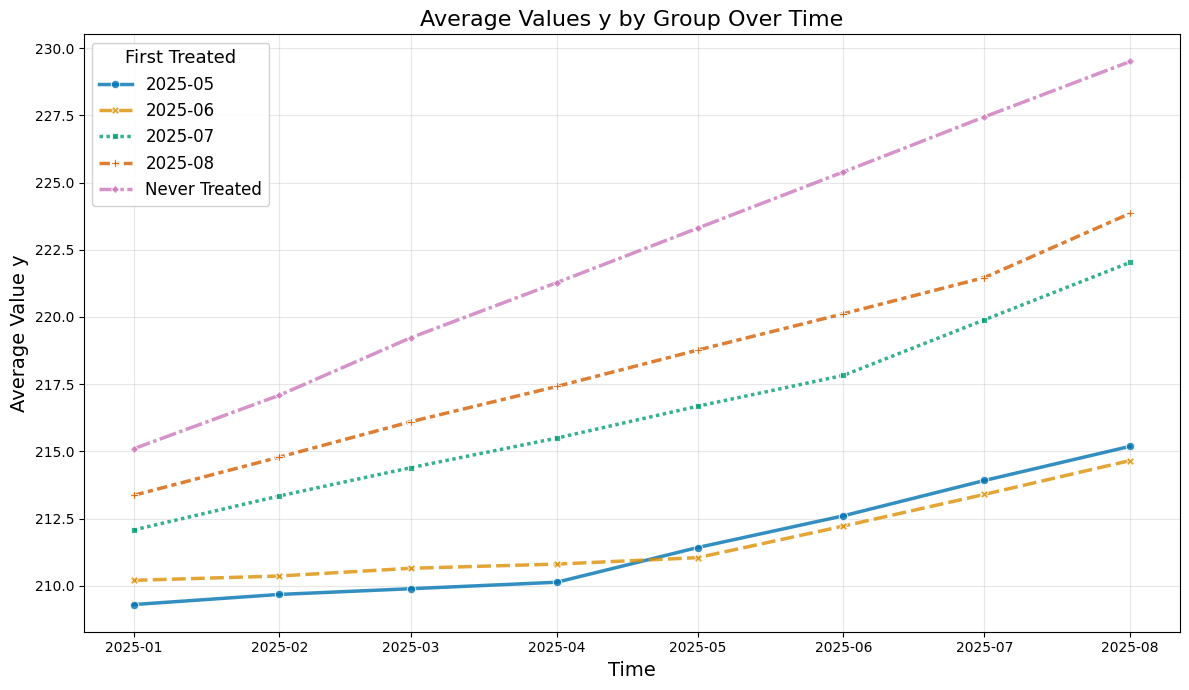

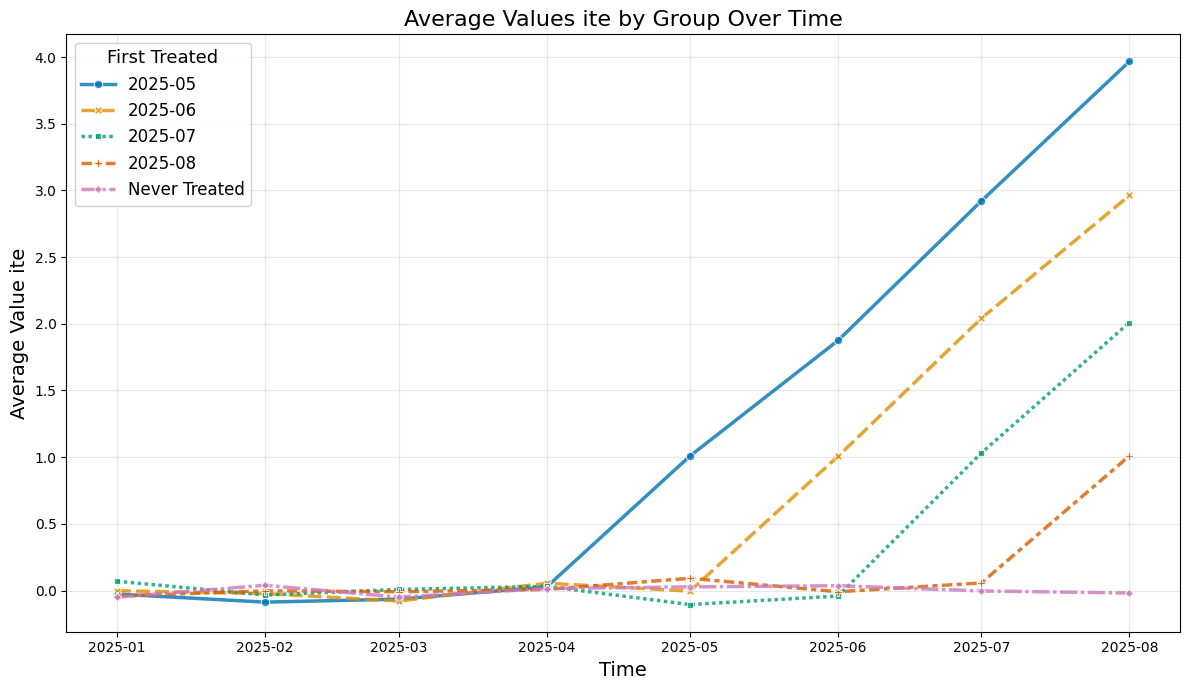

In [4]:
def plot_data_seaborn_improved(df, col_name='y'):
    """
    Create an improved plot with colorblind-friendly features
    
    Parameters:
    -----------
    df : DataFrame
        The dataframe containing the data
    col_name : str, default='y'
        Column name to plot (will use '{col_name}_mean')
    """
    plt.figure(figsize=(12, 7))
    n_colors = df["First Treated"].nunique()
    color_palette = sns.color_palette("colorblind", n_colors=n_colors)

    sns.lineplot(
        data=df,
        x='t',
        y=f'{col_name}_mean',
        hue='First Treated',
        style='First Treated',
        palette=color_palette,
        markers=True,
        dashes=True,
        linewidth=2.5,
        alpha=0.8
    )
    
    plt.title(f'Average Values {col_name} by Group Over Time', fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel(f'Average Value {col_name}', fontsize=14)
    

    plt.legend(title='First Treated', title_fontsize=13, fontsize=12, 
               frameon=True, framealpha=0.9, loc='best')
    
    plt.grid(alpha=0.3, linestyle='-')
    plt.tight_layout()

    plt.show()

# Call the function with your dataframes
plot_data_seaborn_improved(agg_df)
plot_data_seaborn_improved(agg_df, col_name='ite')

In [5]:
dml_data = DoubleMLPanelData(df, y_col="y", d_cols="d", id_col="id", t_col="t", x_cols=["Z1", "Z2", "Z3", "Z4"], datetime_unit="M")
print(dml_data)

================== DoubleMLPanelData Object ==================

------------------ Data summary      ------------------
Outcome variable: y
Treatment variable(s): ['d']
Covariates: ['Z1', 'Z2', 'Z3', 'Z4']
Instrument variable(s): None
Time variable: t
Id variable: id
No. Observations: 5000

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Columns: 12 entries, id to First Treated
dtypes: datetime64[s](2), float64(8), int64(1), object(1)
memory usage: 3.7+ MB



In [6]:
# control_group = "not_yet_treated"
control_group = "never_treated"

gt_combinations = "all"
#gt_combinations = "standard"

ml_g = LGBMRegressor(n_estimators=500, learning_rate=0.01, verbose=-1)
ml_m = LGBMClassifier(n_estimators=500, learning_rate=0.01, verbose=-1)

ml_g = LinearRegression()
ml_m = LogisticRegression()

dml_obj = DoubleMLDIDMulti(
    obj_dml_data=dml_data,
    ml_g=ml_g,
    ml_m=ml_m,
    gt_combinations=gt_combinations,
    control_group=control_group,
)

dml_obj.fit()
print(dml_obj)

================== DoubleMLDIDMulti Object ==================

------------------ Data summary      ------------------
Outcome variable: y
Treatment variable(s): ['d']
Covariates: ['Z1', 'Z2', 'Z3', 'Z4']
Instrument variable(s): None
Time variable: t
Id variable: id
No. Observations: 5000

------------------ Score & algorithm ------------------
Score function: observational
Control group: never_treated
Anticipation periods: 0

------------------ Machine learner   ------------------
Learner ml_g: LinearRegression()
Learner ml_m: LogisticRegression()
Out-of-sample Performance:
Regression:
Learner ml_g0 RMSE: [[1.40819196 1.44505628 1.41728035 1.379876   1.39455406 1.37787884
  1.41904666 1.43565448 1.40797579 1.38017852 1.40451927 1.38072431
  1.43039705 1.37694706 1.34678838 1.34816616 1.37326228 1.37028313
  1.42504859 1.40519018 1.41838418 1.38843531 1.40401396 1.44212802
  1.4162496  1.38217708 1.39642643 1.37807542 1.4217658  1.44046735
  1.41240661 1.38467958 1.40290054 1.38110169 

(<Figure size 1200x800 with 5 Axes>,
 [<Axes: title={'center': 'First Treated: 2025-05'}, ylabel='Effect'>,
  <Axes: title={'center': 'First Treated: 2025-06'}, ylabel='Effect'>,
  <Axes: title={'center': 'First Treated: 2025-07'}, ylabel='Effect'>,
  <Axes: title={'center': 'First Treated: 2025-08'}, xlabel='Evaluation Period', ylabel='Effect'>])

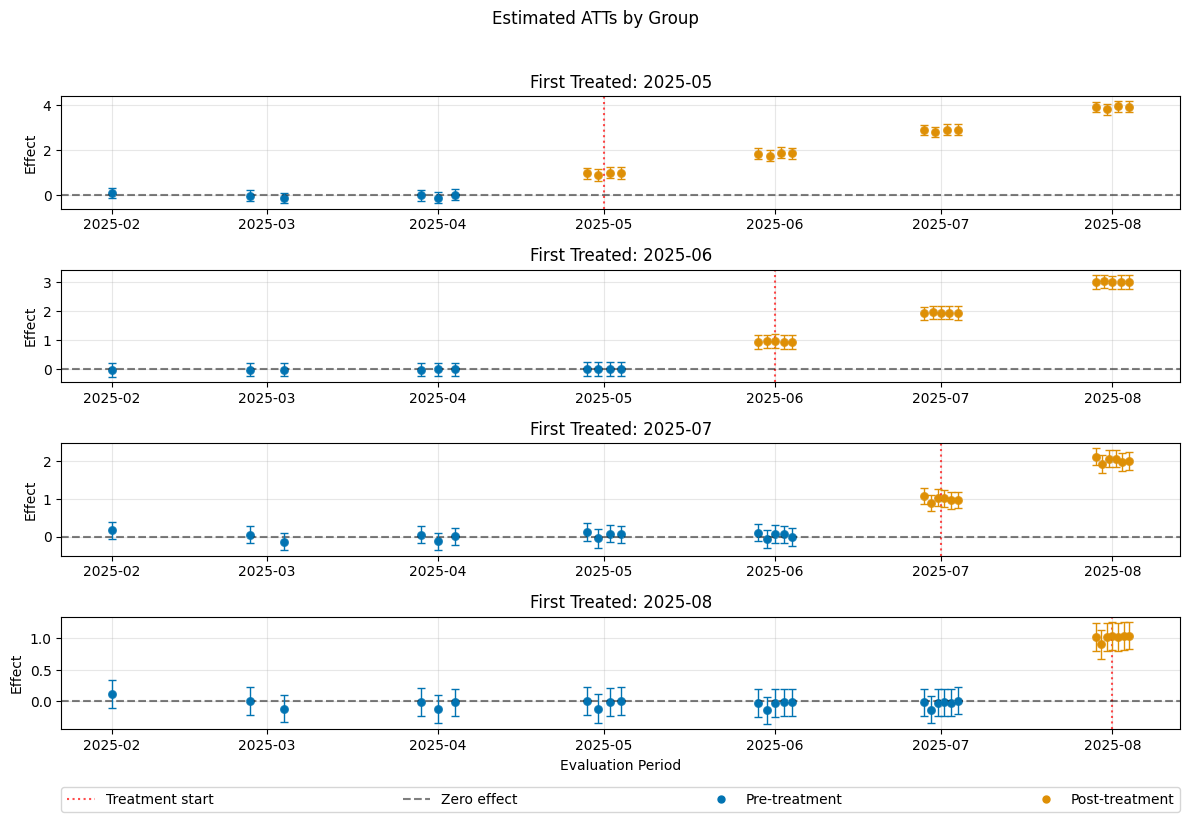

In [11]:
dml_obj.bootstrap()
dml_obj.plot_effects(default_jitter=0.1)

In [8]:
dml_obj.sensitivity_analysis()
print(dml_obj.sensitivity_summary)

================== Sensitivity Analysis ==================

------------------ Scenario          ------------------
Significance Level: level=0.95
Sensitivity parameters: cf_y=0.03; cf_d=0.03, rho=1.0

------------------ Bounds with CI    ------------------
                              CI lower  theta lower     theta  theta upper  \
ATT(2025-05,2025-01,2025-02) -0.109525     0.006676  0.102392     0.198107   
ATT(2025-05,2025-01,2025-03) -0.235913    -0.122100 -0.025312     0.071477   
ATT(2025-05,2025-02,2025-03) -0.338899    -0.226328 -0.131312    -0.036296   
ATT(2025-05,2025-01,2025-04) -0.209205    -0.096719 -0.003033     0.090654   
ATT(2025-05,2025-02,2025-04) -0.317787    -0.200853 -0.105774    -0.010694   
...                                ...          ...       ...          ...   
ATT(2025-08,2025-03,2025-08)  0.825698     0.931629  1.019466     1.107304   
ATT(2025-08,2025-04,2025-08)  0.841346     0.947790  1.034559     1.121329   
ATT(2025-08,2025-05,2025-08)  0.831890  

================== DoubleMLDIDAggregation Object ==================
 Group Aggregation 

------------------ Overall Aggregated Effects ------------------
    coef  std err         t  P>|t|    2.5 %   97.5 %
1.745067 0.026549 65.731185    0.0 1.693033 1.797101
------------------ Aggregated Effects         ------------------
             coef   std err          t  P>|t|     2.5 %    97.5 %
2025-05  2.401745  0.035213  68.206319    0.0  2.332729  2.470761
2025-06  1.969894  0.034375  57.305166    0.0  1.902519  2.037268
2025-07  1.507049  0.038340  39.307637    0.0  1.431904  1.582194
2025-08  1.013121  0.049838  20.328317    0.0  0.915440  1.110801
------------------ Additional Information     ------------------
Control Group: never_treated
Anticipation Periods: 0
Score: observational



/opt/venv/lib/python3.12/site-packages/doubleml/did/did_aggregation.py:328: UserWarning: Joint confidence intervals require bootstrapping which hasn't been performed yet. Automatically applying '.aggregated_frameworks.bootstrap(method="normal", n_rep_boot=500)' with default values. For different bootstrap settings, call bootstrap() explicitly before plotting.
  warnings.warn(


(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Aggregated Treatment Effects'}, ylabel='Effect'>)

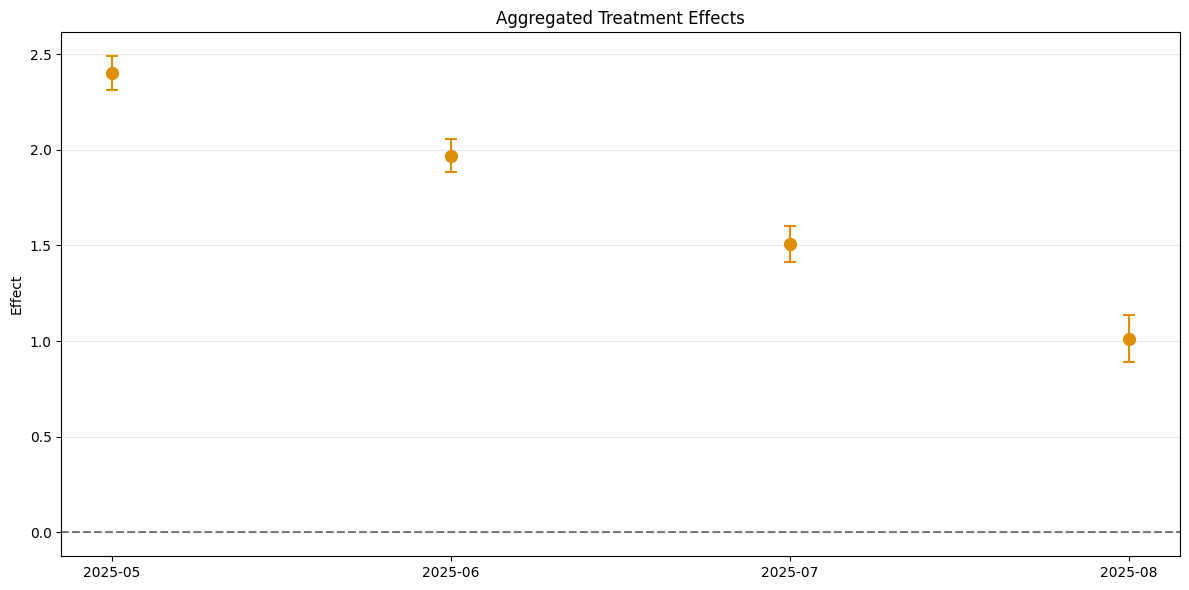

In [9]:
aggregated = dml_obj.aggregate("group")
print(aggregated)
aggregated.plot_effects()

================== DoubleMLDIDAggregation Object ==================
 Event Study Aggregation 

------------------ Overall Aggregated Effects ------------------
    coef  std err         t  P>|t|    2.5 %   97.5 %
2.448411 0.029846 82.033602    0.0 2.389914 2.506909
------------------ Aggregated Effects         ------------------
               coef   std err          t     P>|t|     2.5 %    97.5 %
-6 months  0.118584  0.063783   1.859198  0.062999 -0.006427  0.243596
-5 months  0.021101  0.043800   0.481754  0.629981 -0.064746  0.106947
-4 months -0.041159  0.033809  -1.217373  0.223462 -0.107424  0.025107
-3 months -0.006282  0.029213  -0.215052  0.829727 -0.063539  0.050974
-2 months -0.013714  0.027415  -0.500233  0.616911 -0.067447  0.040019
-1 months -0.002954  0.026243  -0.112548  0.910389 -0.054390  0.048482
0 months   0.984152  0.025663  38.349080  0.000000  0.933853  1.034450
1 months   1.944027  0.031349  62.012347  0.000000  1.882584  2.005470
2 months   2.956757  0.038780 

/opt/venv/lib/python3.12/site-packages/doubleml/did/did_aggregation.py:328: UserWarning: Joint confidence intervals require bootstrapping which hasn't been performed yet. Automatically applying '.aggregated_frameworks.bootstrap(method="normal", n_rep_boot=500)' with default values. For different bootstrap settings, call bootstrap() explicitly before plotting.
  warnings.warn(


(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Aggregated Treatment Effects'}, ylabel='Effect'>)

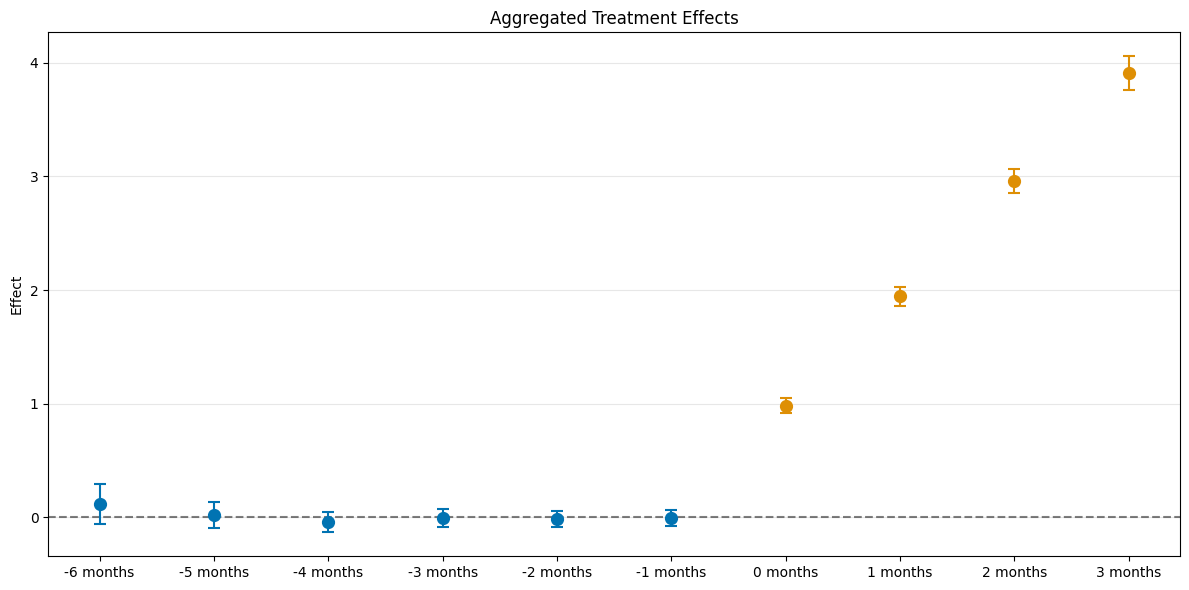

In [10]:
aggregated_eventstudy = dml_obj.aggregate("eventstudy")
print(aggregated_eventstudy)
aggregated_eventstudy.plot_effects()